In [1]:
import torch
import clip

from cppn import CPPN, Sampler

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output, display
import time
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Init CLIP

In [3]:
model, preprocess = clip.load("ViT-B/32", device=device)

# Create normalization tensors on the active device
img_mean = torch.tensor(preprocess.transforms[-1].mean, device=device, dtype=torch.float32).reshape(1, -1, 1, 1)
img_std = torch.tensor(preprocess.transforms[-1].std, device=device, dtype=torch.float32).reshape(1, -1, 1, 1)

In [4]:
# text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
# model.encode_text(text).shape

# Init CPPN

In [5]:
net_size = [512, 128, 128, 8]

num_nulls = 0
dim_in = 3 + num_nulls + 1 # 3 spatial coords + 4 null + z
dim_z = 16
dim_c = 3

# Fourier Features settings
proj_dims = [128]
proj_scales = [3 for i in proj_dims]
projection_config = (proj_dims, proj_scales)
print(net_size)

cppn = CPPN(
    net_size=net_size,
    dim_in=dim_in,
    dim_z=dim_z,
    dim_c=dim_c,
    projection_config=projection_config,
    use_fourier_features=False,
).cuda()

sampler = Sampler(cppn)

[512, 128, 128, 8]


C:\Users\Heysoos\Documents\Pycharm Projects\cppn_exploration\cppn.py:134: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  spacecoords = [torch.cuda.FloatTensor(c) for c in spacecoords]


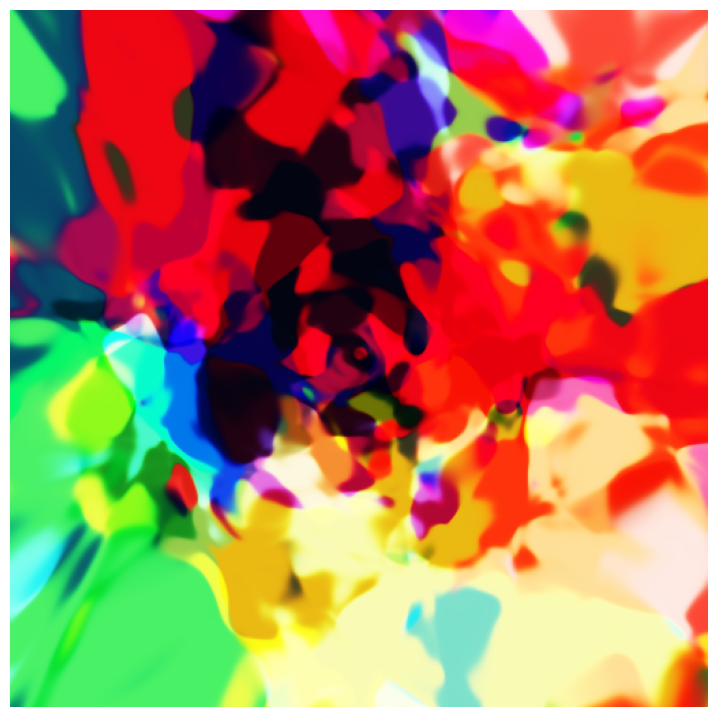

In [6]:
cppn.reinit()

scale = 1
z_scale = 1
xres = yres = 512
z = z_scale * torch.randn(1, dim_z).cuda()
coords = cppn._coordinates(scale, xres, yres, z, num_nulls=num_nulls)

x = sampler.generate_img(cppn, z, scale, xres, yres, coords)
sampler.imshow(x)

# Training

In [7]:
def make_loss(text):
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    def clip_loss(image):
        # image expected in [0, 1], shape (B,C,H,W)
        image = torch.nn.functional.interpolate(image, size=224)
        image = (image - img_mean) / img_std
        with torch.no_grad():
            image_features = model.encode_image(image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = (image_features @ text_features.T).squeeze()
        return -similarity

    return clip_loss

# clip_loss = make_loss(text)

In [8]:
def plot_training(x, losses):
    plt.clf()
    # prepare images as (B, H, W, C)
    B, xres, yres, C = x.shape
    x_vis = x.reshape(B, xres, yres, C)
    # x_vis = x_vis.numpy()
    #choice = np.random.choice(B, size=B, replace=False)

    fig = plt.figure(figsize=(7, 7))
    gs = fig.add_gridspec(2, 4, height_ratios=[4, 1])

    num_rows = num_cols = int(np.sqrt(B))
    grid = gs[0, :].subgridspec(num_rows, num_cols, wspace=0.05, hspace=0.05)

    # 4x4 image grid
    axs_img = [fig.add_subplot(grid[r, c]) for r in range(num_rows) for c in range(num_cols)]
    for i, ax_img in enumerate(axs_img):
        #img = x_vis[choice[i]]
        img = x_vis[i]
        # normalize to [0, 1] per image for safe display
        vmin, vmax = img.min(), img.max()
        if vmax > 1.0 or vmin < 0.0:
            rng = (vmax - vmin) + 1e-8
            img = (img - vmin) / rng
        if img.shape[-1] == 1:
            ax_img.imshow(img[..., 0], cmap='gray', vmin=0.0, vmax=1.0)
        else:
            ax_img.imshow(np.clip(img, 0.0, 1.0))
        ax_img.axis('off')

    # full-width loss plot
    ax_loss = fig.add_subplot(gs[1, :])
    ax_loss.plot(losses, color='tab:blue')
    ax_loss.set_title('Training loss')
    ax_loss.set_xlabel('Step')
    ax_loss.set_ylabel('Sim')
    ax_loss.grid(True, alpha=0.3)

    clear_output(wait=True)
    display(fig)
    time.sleep(0.001)
    plt.close(fig)

# EvoTorch

In [9]:
from evotorch import Problem
from evotorch.algorithms import SNES, PyCMAES
from evotorch.logging import StdOutLogger

In [10]:
goal = "a bumblebee"
text = clip.tokenize([goal]).to(device)
clip_loss = make_loss(text)

# Pre-compute and cache normalized text features for CLIP similarity
with torch.no_grad():
    _text_features = model.encode_text(text)
    _text_features = _text_features / _text_features.norm(dim=-1, keepdim=True)

# Optimize CPPN parameters with SNES to maximize CLIP similarity (fixed z)

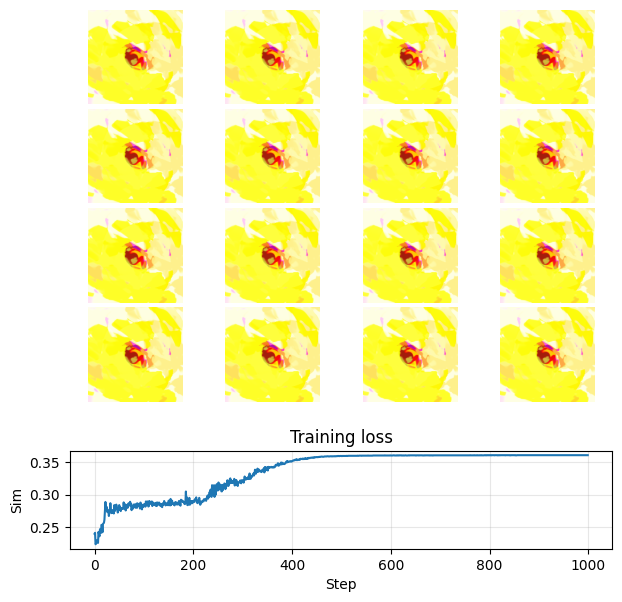

<Figure size 640x480 with 0 Axes>

In [11]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

# Fixed z already created above as `z`; build coordinates once at a smaller res for speed
opt_xres = opt_yres = 160
opt_scale = 1.0
with torch.no_grad():
    coords_fixed = cppn._coordinates(opt_scale, opt_xres, opt_yres, z, flatten=True, batch_size=1, num_nulls=num_nulls)

# NEW: capture configuration and buffers
CAPTURE_POP = False
LAST_POP_IMAGES = []  # list of np.ndarray images (H, W, C) in [0,1]
POP_SAVE_DIR = Path("outputs/snes_pop")
POP_SAVE_DIR.mkdir(parents=True, exist_ok=True)
plot_every = 20

@torch.no_grad()
def eval_clip_similarity_for_current_cppn(return_image: bool = False) -> torch.Tensor:
    """Evaluate CLIP similarity for the current CPPN params and fixed z/coords.
    returns: scalar tensor on CUDA (higher is better)
    """
    out = cppn.forward(coords_fixed)  # (1, Npix, C)
    img = out.reshape(1, opt_yres, opt_xres, dim_c).permute(0, 3, 1, 2).contiguous()  # (1,C,H,W)
    # img = torch.clamp(img, 0.0, 1.0) # not needed because of sigmoid
    img224 = torch.nn.functional.interpolate(img, size=224, mode='bilinear', align_corners=False)
    normed = (img224 - img_mean) / img_std
    image_features = model.encode_image(normed)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    sim = (image_features @ _text_features.T).squeeze(-1)  # (1,)

    if return_image:
        img_hwc = out.reshape(opt_yres, opt_xres, dim_c).cpu().numpy()
        return sim, img_hwc
    return sim.sum()

# Vectorize parameters
with torch.no_grad():
    param_vec0 = parameters_to_vector(cppn.parameters()).clone()

# Define EvoTorch objective over parameter vectors
# Move center vector to model/problem device for SNES
param_vec0 = param_vec0.to('cuda')
def snes_params_objective(solutions: torch.Tensor) -> torch.Tensor:
    """Maximization objective: CLIP similarity for each parameter vector.
    solutions: (D,) or (B,D) on device
    returns: (B,) or (1,) similarities
    """
    with torch.no_grad():
        # Cache original params to restore after batch
        orig_vec = parameters_to_vector(cppn.parameters()).clone()
        batched = solutions.dim() == 2
        sols = solutions if batched else solutions.unsqueeze(0)
        sims = []

        for i in range(sols.shape[0]):
            vec = sols[i].to(orig_vec.device)
            vector_to_parameters(vec, cppn.parameters())
            if CAPTURE_POP:
                sim, img = eval_clip_similarity_for_current_cppn(return_image=True)
                LAST_POP_IMAGES.append(img)
            else:
                sim = eval_clip_similarity_for_current_cppn()
            sims.append(sim)

        # Restore original params
        vector_to_parameters(orig_vec, cppn.parameters())
        sims_t = torch.stack(sims, dim=0)
        return sims_t if batched else sims_t.squeeze(0)

# Rebuild the optimization problem for parameter space
problem = Problem(
    "max",
    snes_params_objective,
    solution_length=param_vec0.numel(),
    device=device,
)

# Configure SNES centered at current parameters
popsize = 16
stdev_init = 0.1
max_generations = 1000

# algo = SNES(
#     problem,
#     popsize=popsize,
#     stdev_init=stdev_init,
#     center_init=param_vec0,
# )

algo = PyCMAES(
    problem,
    popsize=popsize,
    stdev_init=stdev_init,
    center_init=param_vec0,
    separable=True
)

_ = StdOutLogger(algo, interval=20)

best_scores = []

for gen in range(max_generations):
    # Capture population every N generations (adjust frequency as needed)
    capture_now = (gen == 0) or ((gen + 1) % plot_every == 0)
    if capture_now:
        LAST_POP_IMAGES = []
        
    CAPTURE_POP = capture_now
    algo.step()
    CAPTURE_POP = False

    status = algo.status
    best_sol = status.get('best', None) or status.get('pop_best', None) or status.get('center', None) or status.get('mean', None)
    if best_sol is None:
        raise RuntimeError("SNES status has no best/center/mean")
    best_vec = getattr(best_sol, 'values', best_sol).clone()

    # Set model to best params and evaluate
    with torch.no_grad():
        vector_to_parameters(best_vec, cppn.parameters())
        best_score = eval_clip_similarity_for_current_cppn().item()
    best_scores.append(best_score)

    # Periodic preview at opt resolution
    if (gen + 1) % plot_every == 0 or gen == 0:
        # with torch.no_grad():
        #     out_best = cppn.forward(coords_fixed).reshape(opt_yres, opt_xres, dim_c).cpu().numpy()
        # plt.figure(figsize=(4, 4))
        # plt.imshow(np.clip(out_best, 0.0, 1.0))
        # plt.title(f"Gen {gen+1} | best sim: {best_score:.4f}")
        # plt.axis('off')
        # clear_output(wait=True)
        # display(plt.gcf())
        # plt.close()

        plot_training(np.stack(LAST_POP_IMAGES), best_scores)

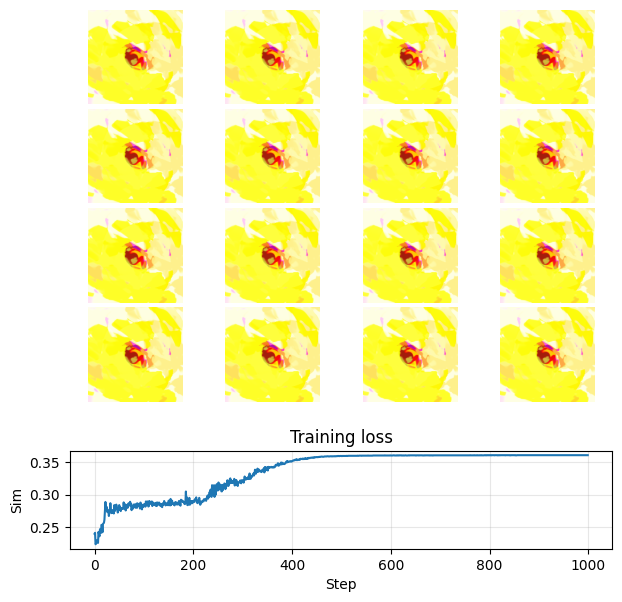

<Figure size 640x480 with 0 Axes>

In [12]:
plot_training(np.stack(LAST_POP_IMAGES), best_scores)

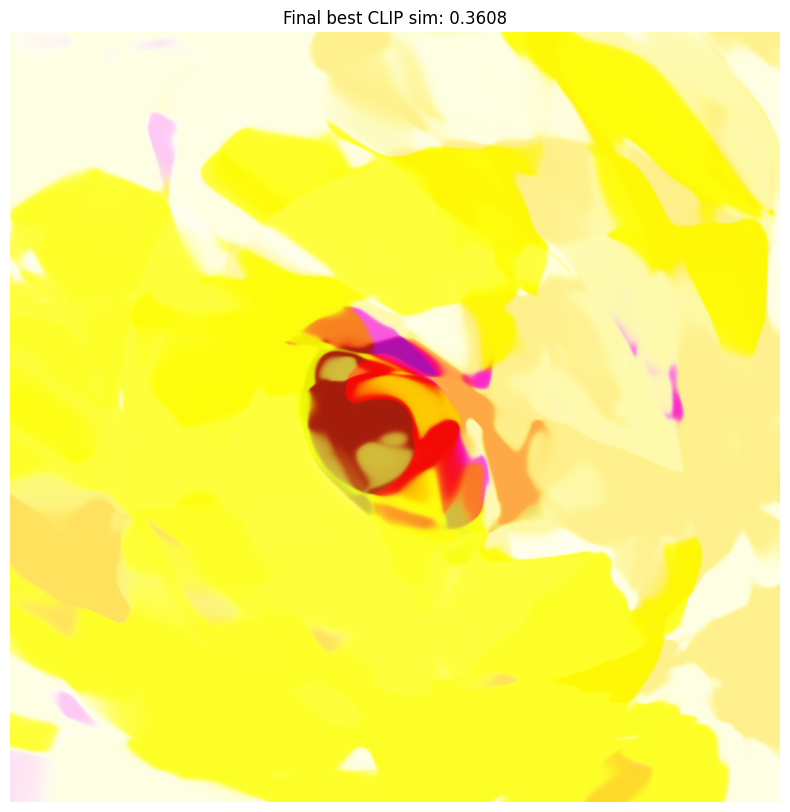

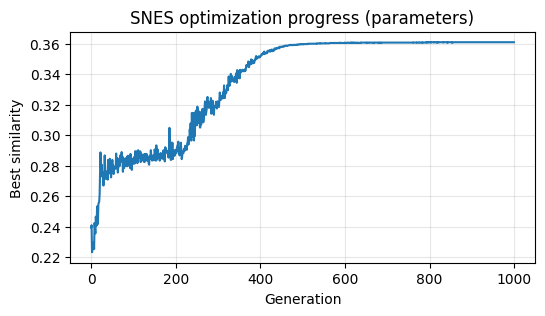

In [13]:

# Final: ensure model has the best params and render high-res
# (cleanup duplicate blocks and avoid boolean ops on tensors)
final_best = algo.status.get('pop_best', None)
if final_best is None:
    final_best = algo.status.get('center', None)
if final_best is None:
    final_best = algo.status.get('mean', None)
if final_best is None:
    raise RuntimeError("SNES status has no best/center/mean at final step")
final_vec = getattr(final_best, 'values', final_best).clone()

h_xres, h_yres = 1024, 1024
with torch.no_grad():
    vector_to_parameters(final_vec, cppn.parameters())
    hi_coords = cppn._coordinates(scale, h_xres, h_yres, z, flatten=True, batch_size=1, num_nulls=num_nulls)
    hi_img = cppn.forward(hi_coords).reshape(h_xres, h_yres, dim_c).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(np.clip(hi_img, 0.0, 1.0))
plt.title(f"Final best CLIP sim: {eval_clip_similarity_for_current_cppn().item():.4f}")
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(best_scores)
plt.xlabel('Generation')
plt.ylabel('Best similarity')
plt.title('SNES optimization progress (parameters)')
plt.grid(True, alpha=0.3)
plt.show()